# 💬[Kaggle] Quora Quetions Pairs

* **Competition Site** : <https://www.kaggle.com/competitions/quora-question-pairs/data>


* **Quora** : 질문을 하고 다른 사용자들로부터 답변을 받을 수 있는 서비스
  - **Target** : 이 서비스에 올라온 질문들 중 어던 질문이 서로 유사한지 판단하는 모델을 만듬. [텍스트 유사도]
  - **Preprocessing** : **문장의 길이와 어휘 빈도 분석**을 통한 전처리
  - **Model** : Quara에서는 중복 검사를 **Random Forest**로 진행하고 있음.

# 👻Library Load

In [22]:
import os
import json
from pathlib import Path
from joblib import dump, load
import joblib
import warnings
warnings.filterwarnings("ignore")

# EDA & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing library
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Train/Test Split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Classification Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


# Metric
from sklearn.metrics import accuracy_score, log_loss, make_scorer


# DL Model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import MaxNorm 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)


In [2]:
DATA_IN_PATH = os.path.join(os.getcwd(), 'data')
train_data = pd.read_csv(os.path.join(DATA_IN_PATH, 'train.csv'))

In [3]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
print("파일 크기 : ")
for file in os.listdir(DATA_IN_PATH) : 
    if 'csv' in file and 'zip' not in file : 
        print(file.ljust(30) + str(round(os.path.getsize(os.path.join(DATA_IN_PATH,file)) / 1000000, 2)) + 'MB')

파일 크기 : 
sample_submission.csv         22.35MB
test.csv                      477.59MB
train.csv                     63.4MB


In [5]:
print("전체 학습 데이터의 개수 : {}".format(len(train_data)))

전체 학습 데이터의 개수 : 404290


**nan 값 확인**

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [9]:
bool_q1 = pd.isnull(train_data['question1'])
bool_q2 = pd.isnull(train_data['question2'])
display(train_data[bool_q1])
display(train_data[bool_q2])

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


**두 질문을 한번에 분석하기 위해 질문들 합치기**

In [10]:
train_set = pd.Series(train_data['question1'].tolist() + train_data['question2'].tolist()).astype(str)
train_set.head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object

----------------------

# 👻EDA

1. **질문 중복 분석**
2. **라벨 빈도 분석**
3. **문자 분석**
4. **단어 분석**

## 🤡[EDA] 질문 중복 분석

In [25]:
print('Train 데이터의 총 질문 수 : {}'.format(len(np.unique(train_set))))
print('반복해서 나타나는 질문의 수 : {}'.format(np.sum(train_set.value_counts()>1)))


Train 데이터의 총 질문 수 : 537361
반복해서 나타나는 질문의 수 : 111873


중복 최대 개수 : 161
중복 최소 개수 : 1
중복 평균 개수 : 1.50472401234924
중복 표준편차  : 1.9114373539452214
중복 중간 길이 : 1.0
제1사분위 중복 : 1.0
제3사분위 중복 : 1.0
90% 중복 개수 : 2.0
95% 중복 개수 : 3.0
99% 중복 개수 : 9.0


Text(0, 0.5, 'Number of occurrence of questions')

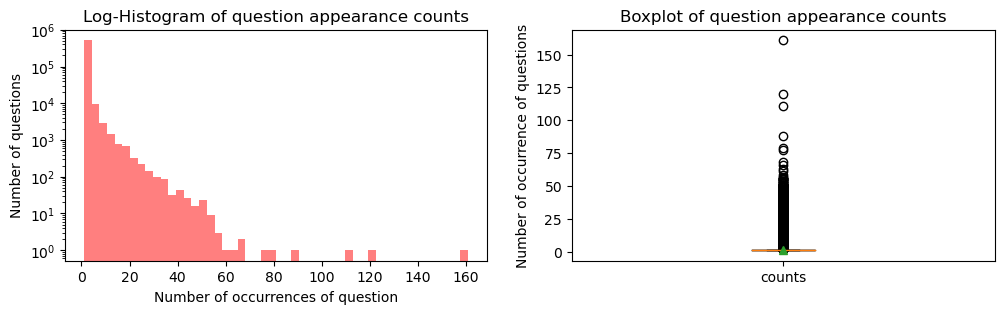

In [45]:
# 질문 중복 횟수에 대한 통계량
print('중복 최대 개수 : {}'.format(np.max(train_set.value_counts())))
print('중복 최소 개수 : {}'.format(np.min(train_set.value_counts())))
print('중복 평균 개수 : {}'.format(np.mean(train_set.value_counts())))
print('중복 표준편차  : {}'.format(np.std(train_set.value_counts())))
print('중복 중간 길이 : {}'.format(np.median(train_set.value_counts())))
print('제1사분위 중복 : {}'.format(np.percentile(train_set.value_counts(), 25)))
print('제3사분위 중복 : {}'.format(np.percentile(train_set.value_counts(), 75)))
print('90% 중복 개수 : {}'.format(np.percentile(train_set.value_counts(), 90)))
print('95% 중복 개수 : {}'.format(np.percentile(train_set.value_counts(), 95)))
print('99% 중복 개수 : {}'.format(np.percentile(train_set.value_counts(), 99)))



# Histogram & Box plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
axes[0].hist(train_set.value_counts(), bins=50, alpha=0.5, color='r', label='word');
axes[0].set_yscale('log')
axes[0].set_title('Log-Histogram of question appearance counts')
axes[0].set_xlabel('Number of occurrences of question')
axes[0].set_ylabel('Number of questions')

axes[1].boxplot([train_set.value_counts()], labels=['counts'], showmeans=True);
axes[1].set_title('Boxplot of question appearance counts')
axes[1].set_ylabel('Number of occurrence of questions')

(-0.5, 799.5, 599.5, -0.5)

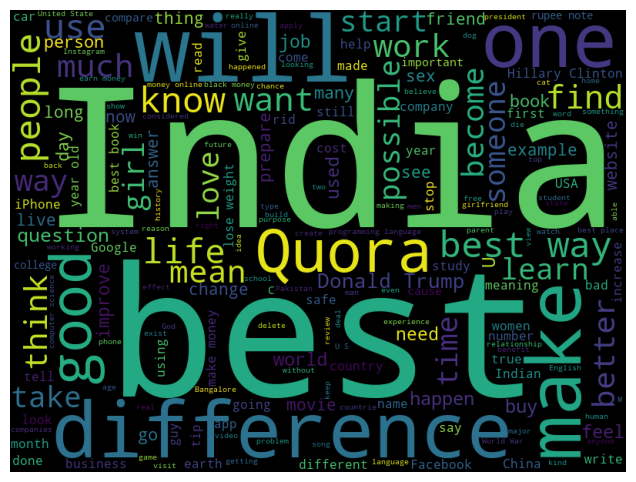

In [49]:
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(" ".join(train_set.astype(str)))
plt.figure(figsize=(10, 6))
plt.imshow(cloud)
plt.axis('off')

## 🤡[EDA] 라벨 빈도 분석

c:\Users\user\anaconda3\envs\nlpproject\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


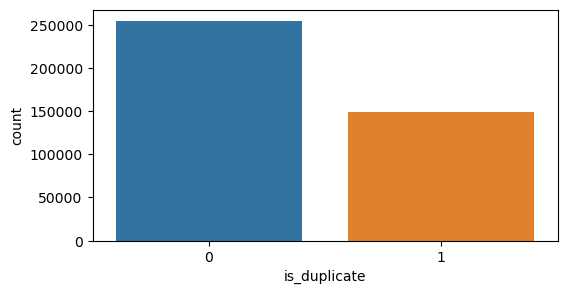

In [54]:
# 라벨 빈도 분석
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['is_duplicate']);

In [57]:
print(f"중복 데이터 : {train_data['is_duplicate'].value_counts()[1]}, 중복 아닌 데이터 : {train_data['is_duplicate'].value_counts()[0]}")

중복 데이터 : 149263, 중복 아닌 데이터 : 255027


* 라벨의 분포가 한쪽으로 편향되어 있음. 전처리 과정에서 라벨의 분포를 균형있게 맞춰줘야 함.

## 🤡[EDA] 문자 분석

In [58]:
# 텍스트 데이터 길이 분석
train_length = train_set.apply(len)

질문 길이 최대값 : 1169
질문 길이 최소값 : 1
질문 길이 평균값 : 59.82254817086745
질문 길이 표준편차  : 31.963731729209687
질문 길이 중간 길이 : 51.0
질문 길이 제1사분위 : 39.0
질문 길이 제3사분위 : 72.0


Text(0, 0.5, 'Question length')

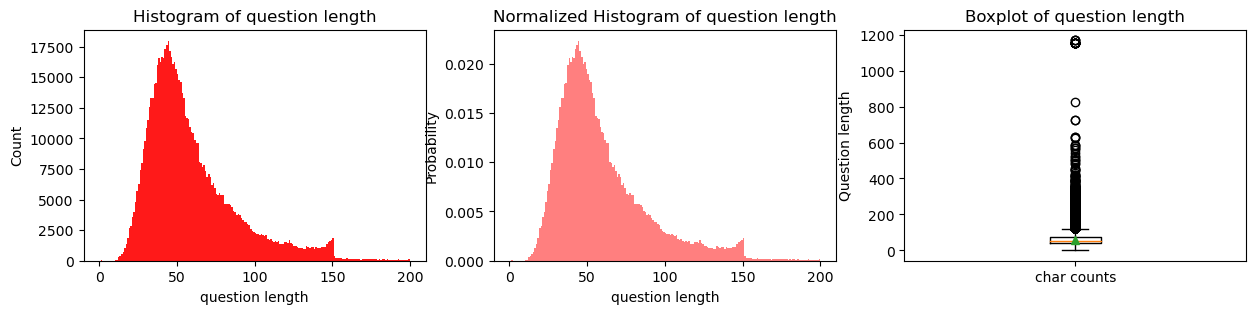

In [64]:
# 질문 길이에 대한 통계량
print('질문 길이 최대값 : {}'.format(np.max(train_length)))
print('질문 길이 최소값 : {}'.format(np.min(train_length)))
print('질문 길이 평균값 : {}'.format(np.mean(train_length)))
print('질문 길이 표준편차  : {}'.format(np.std(train_length)))
print('질문 길이 중간 길이 : {}'.format(np.median(train_length)))
print('질문 길이 제1사분위 : {}'.format(np.percentile(train_length, 25)))
print('질문 길이 제3사분위 : {}'.format(np.percentile(train_length, 75)))

# Histogram & Box plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
axes[0].hist(train_length, bins=200, range = [0, 200], alpha=0.9, color='r', density=False, label='Train Question Length');
axes[0].set_title('Histogram of question length')
axes[0].set_xlabel('question length')
axes[0].set_ylabel('Count')

axes[1].hist(train_length, bins=200, range = [0, 200], alpha=0.5, color='r', density=True, label='Train Question Length');
axes[1].set_title('Normalized Histogram of question length')
axes[1].set_xlabel('question length')
axes[1].set_ylabel('Probability')

axes[2].boxplot(train_length, labels=['char counts'], showmeans=True);
axes[2].set_title('Boxplot of question length')
axes[2].set_ylabel('Question length')

## 🤡[EDA] 단어 분석

In [185]:
train_word_count = train_set.apply(lambda x : len(x.split(' ')))

Text(0, 0.5, 'Probability')

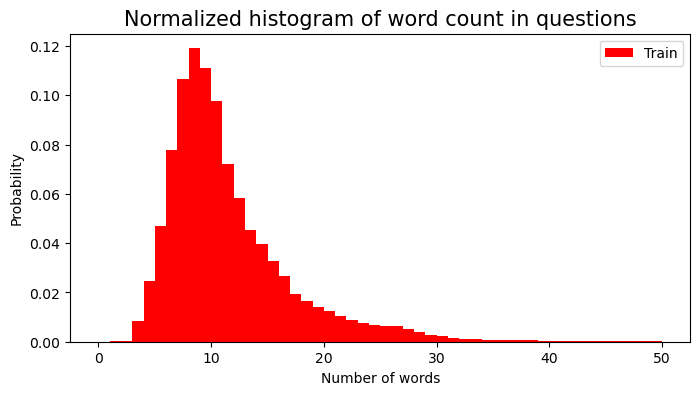

In [188]:
plt.figure(figsize=(8, 4))
plt.hist(train_word_count, bins=50, range=[0, 50], facecolor='r', density=True, label='Train')
plt.title('Normalized histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=10)
plt.ylabel('Probability', fontsize=10)


In [189]:
# 질문 길이에 대한 통계량
print('단어 길이 최대값 : {}'.format(np.max(train_word_count)))
print('단어 길이 최소값 : {}'.format(np.min(train_word_count)))
print('단어 길이 평균값 : {}'.format(np.mean(train_word_count)))
print('단어 길이 표준편차  : {}'.format(np.std(train_word_count)))
print('단어 길이 중간 길이 : {}'.format(np.median(train_word_count)))
print('단어 길이 제1사분위 : {}'.format(np.percentile(train_word_count, 25)))
print('단어 길이 제3사분위 : {}'.format(np.percentile(train_word_count, 75)))
print('단어 길이 80% : {}'.format(np.percentile(train_word_count, 80)))
print('단어 길이 90% : {}'.format(np.percentile(train_word_count, 90)))
print('단어 길이 99% : {}'.format(np.percentile(train_word_count, 99)))


단어 길이 최대값 : 237
단어 길이 최소값 : 1
단어 길이 평균값 : 11.064855672908061
단어 길이 표준편차  : 5.889164008512459
단어 길이 중간 길이 : 10.0
단어 길이 제1사분위 : 7.0
단어 길이 제3사분위 : 13.0
단어 길이 80% : 14.0
단어 길이 90% : 18.0
단어 길이 99% : 31.0


### 🤪 **단어 내용 분석**

* 💬%,$,₹,€,@ : 특수한 상황에서 사용하는 문자 확인
* 💬수학 기호 확인
* 💬문자로 치환 가능한 큰 숫자 확인 ex) '1,000,000,000', '1,000,000'
* 💬HTML Tag 확인

* **Reference : https://www.kaggle.com/code/utkarsh293/tf-idf-weighted-word2vec-model-using-xgboost/notebook**

### 💬%,$,₹,€,@ : 특수한 상황에서 사용하는 문자 확인

In [22]:
def find_special_str(q) :
    for s in q.split() :
        if s in ['$', '₹', '€', '@', '#'] :
            return True
    return False        
special_str = train_set.apply(find_special_str)

In [23]:
train_set[special_str]

161       I got job offer @ Chelmsford-Essex, London wit...
385                        What does @ mean as an emoticon?
2422      I want a real and effective way to make $ 500 ...
8678      A normal distribution with mean 37 and standar...
11631                  How do I make an extra $ 500 a week?
                                ...                        
784804            What are the best laptops under ₹ 60,000?
784991    What are the best games that are compatible on...
792521    Symbols: What is this @ sign called other than...
798709    Why does the RPM indicator blink when I ride t...
805669                             What is # in C language?
Length: 162, dtype: object

### 💬수학 기호 확인

In [32]:
math_str = train_set.apply(lambda x : '[math]' in x)
train_set[math_str]

362       How do I find the zeros of the polynomial func...
764       What is [math]x[/math] if [math]x+\left(\dfrac...
1275      How do I integrate [math]v^3(a^2-v^2)^{\frac{1...
1658           What is the formula of [math](a+b)^3[/math]?
2712      What is [math]\sqrt {2+\sqrt {2+\sqrt {2+\sqrt...
                                ...                        
802690    What is limit of [math]\dfrac{1^4+2^4+3^4....n...
803404       What is the inverse of[math] f(x) =4^x[/math]?
805245    What are some good examples of [math]E=mc^2[/m...
805529    For any [math]A_{n\times n}[/math], is it poss...
806079    What is the angle of intersection of the curve...
Length: 949, dtype: object

### 💬문자로 치환 가능한 큰 숫자 확인 ex) '1,000,000,000', '1,000,000'

In [38]:
def find_bignum_str(q) :
    for s in q.split() :
        if s in [',000,000,000 ',',000,000 ',',000 ', r'([0-9]+)000000000', r'([0-9]+)000000', r'([0-9]+)000'] :
            return True
    return False      
bignum_str = train_set.apply(find_bignum_str)
train_set[bignum_str]

Series([], dtype: object)

In [ ]:
qmarks = np.mean(train_set.apply(lambda x : '?' in x))                                      # 물음표가 있는지 확인.
fullstop = np.mean(train_set.apply(lambda x : '.' in x))                                    # 마침표 확인
capital_first = np.mean(train_set.apply(lambda x : x[0].isupper()))                         # 첫 글자 대문자인지 확인
capitals = np.mean(train_set.apply(lambda x : max([y.isupper() for y in x])))               # 대문자가 있는지 확인

In [40]:
# 질문 단어 구성 대한 통계량
print('?가 있는 질문           : {:.2f}%'.format(qmarks*100))
print('.가 있는 질문           : {:.2f}%'.format(fullstop*100))
print('$,₹,€,@,#가 있는 질문   : {:.2f}%'.format(len(train_set[special_str])/len(train_set)*100))
print('수학 기호가 있는 질문    : {:.2f}%'.format(len(train_set[math_str])/len(train_set)*100))
print('첫 글자 대문자인 질문    : {:.2f}%'.format(capital_first*100))
print('대문자가 있는 질문       : {:.2f}%'.format(capitals*100))

?가 있는 질문           : 99.87%
.가 있는 질문           : 6.31%
$,₹,€,@,#가 있는 질문   : 0.02%
수학 기호가 있는 질문    : 0.12%
첫 글자 대문자인 질문    : 99.81%
대문자가 있는 질문       : 99.95%


----------------------

# 👻Preprocessing

* 🤡**Null 값 처리**
* 🤡**중복 데이터 제거**
* 🤡**DownSampling : positive/negative비율 맞춰주기**
* 🤡**단어 전처리**
    * 💬%,$,₹,€,@,# : 특수한 상황에서 사용하는 문자 변환
    * 💬**수학 기호 제거**
    * 💬**단어 축소 표현(contradictions) 확장**
    * 💬**불용어 처리**
    * 💬**HTML Tag 제거**
    * 💬**puntuation 기호 제거**
    * 💬**double spacebar 제거**
    * 💬**양 옆 공백 제거**

* 🤡**Word2Vec**
* 🤡**TF-IDF**
* 🤡**TF-IDF weighted Word2Vec**


In [13]:
DATA_IN_PATH = os.path.join(os.getcwd(), 'data')
train_data = pd.read_csv(os.path.join(DATA_IN_PATH, 'train.csv'))

In [14]:
before_len = len(train_data)

## 🤡null값 삭제

In [15]:
bool_q1 = pd.isnull(train_data['question1'])
bool_q2 = pd.isnull(train_data['question2'])
null_q1, null_q2 = bool_q1.sum(), bool_q2.sum()

In [16]:
display(train_data[bool_q1])
display(train_data[bool_q2])

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [17]:
train_data.dropna(inplace=True)

In [18]:
bool_q1 = pd.isnull(train_data['question1'])
bool_q2 = pd.isnull(train_data['question2'])
display(train_data[bool_q1])
display(train_data[bool_q2])

,id,qid1,qid2,question1,question2,is_duplicate


,id,qid1,qid2,question1,question2,is_duplicate


In [19]:
print(f'Null값 제거 전 : {before_len}, question1 Null 개수 : {null_q1} question2 Null 개수 : {null_q2}, Null값 제거 후 : {len(train_data)}')

Null값 제거 전 : 404290, question1 Null 개수 : 1 question2 Null 개수 : 2, Null값 제거 후 : 404287


In [20]:
train_data.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

## 🤡중복 데이터 제거

In [21]:
print(f"중복 제거 전 개수 : {len(train_data)}")
train_data = train_data.drop_duplicates()
print(f"중복 제거 전 후 : {len(train_data)}")

중복 제거 전 개수 : 404287
중복 제거 전 후 : 404287


## 🤡DownSampling : positive/negative비율 맞춰주기

In [22]:
train_pos_data = train_data.loc[train_data['is_duplicate'] == 1]
train_neg_data = train_data.loc[train_data['is_duplicate'] == 0]

class_difference = len(train_neg_data)- len(train_pos_data)
sample_frac = 1 - (class_difference/len(train_neg_data))

# down sampling
train_neg_data = train_neg_data.sample(frac=sample_frac)

print("긍정 질문 개수 : {}".format(len(train_pos_data)))
print("부정 질문 개수 : {}".format(len(train_neg_data)))

긍정 질문 개수 : 149263
부정 질문 개수 : 149263


In [23]:
train_data = pd.concat([train_neg_data, train_pos_data])

## 🤡**단어 전처리**

* 💬**대문자 소문자로 변환**

* 💬**\%,\$,₹,€,\@,# : 특수한 상황에서 사용하는 문자 변환**

* 💬**수학 기호 제거**

* 💬**단어 축소 표현(contradictions) 확장**

* 💬**불용어(stop words) 처리**

* 💬**HTML Tag 제거**

* 💬**puntuation 기호 제거**

* 💬**double spacebar 제거**

* 💬**양 옆 공백 제거(strip)**

In [24]:
from nltk.corpus import stopwords
'''[Reference]
1. preprocessing process : https://www.kaggle.com/code/utkarsh293/tf-idf-weighted-word2vec-model-using-xgboost/notebook
2. contractions : https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions

'''
STOP_WORDS = stopwords.words("english")
PUNTUATION_FILTERS = '[^a-z0-9A-Z_]'
DOUBLE_FILTERS = '\s+'
change_filter = re.compile(PUNTUATION_FILTERS)
double_filter = re.compile(DOUBLE_FILTERS)

def preprocess(q):
    # 대문자 소문자로 변환, 양옆 공백 제거
    q = str(q).lower().strip()
    
    # 특수한 상황에 쓰이는 문자열 변환
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # 수학 기호 제거 
    q = q.replace('[math]', '')
    
    # Decontracting words
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    # 압축 표현 확장
    q_decontracted = []
    for word in q.split():
        if word in contractions:
            word = contractions[word]
        # 불용어 처리
        if word not in STOP_WORDS : 
            q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # HTML tags 제거
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # puntuation 기호 제거
    q = re.sub(change_filter, " ", q)
    # 이중 띄어쓰기 띄어쓰기 하나로 변경
    q = re.sub(double_filter, " ", q)
    # 마지막으로 양 옆 공백 제거 후 반환 
    return q.strip()

In [25]:
q1_lst = [s for s in train_data['question1']]
q2_lst = [s for s in train_data['question2']]

filtered_q1, filtered_q2 = list(), list()

for q in q1_lst :
    filtered_q1.append(preprocess(q))
for q in q2_lst :
    filtered_q2.append(preprocess(q))

## 🤡Word2Vec

In [26]:
import gensim

questions = filtered_q1 + filtered_q2

ques_sent = []
for sentence in questions:
    ques_sent.append(gensim.utils.simple_preprocess(sentence))

model  = gensim.models.Word2Vec(window=2,min_count=3,sg=1,vector_size=128)
model.build_vocab(ques_sent)
model.train(corpus_iterable=ques_sent,total_examples= model.corpus_count, epochs=model.epochs)
w2v = dict(zip(model.wv.index_to_key, (model.wv.vectors.round(6))))


## 🤡TF-IDF 

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
tfidf1 = TfidfVectorizer()
tfidf1.fit_transform(questions)

<597052x69371 sparse matrix of type '<class 'numpy.float64'>'
	with 3249452 stored elements in Compressed Sparse Row format>

## 🤡TF-IDF weighted Word2Vec 

In [ ]:
word2weight = [(w, round(tfidf1.idf_[i])) for w, i in tfidf1.vocabulary_.items()]
word2weight = dict(word2weight)

In [73]:
model.wv.similar_by_word('trump',topn=15)

[('donald', 0.8374648094177246),
 ('trumps', 0.705585777759552),
 ('sanders', 0.6899927258491516),
 ('democrats', 0.6791077852249146),
 ('mike', 0.6653683185577393),
 ('cruz', 0.6641175746917725),
 ('putin', 0.6502425074577332),
 ('giuliani', 0.6495426893234253),
 ('promises', 0.6490954756736755),
 ('bernie', 0.6471933722496033),
 ('pence', 0.6466492414474487),
 ('concede', 0.6445223093032837),
 ('begging', 0.6436761617660522),
 ('reagan', 0.6434751749038696),
 ('endorsed', 0.642966628074646)]

In [51]:
def document_vector(doc):
    if len(doc.split()) < 2:
        return np.zeros(shape=(128))
    else:
        doc_vec = []
        tfidf_weight_sum = 0
        for word in doc.split():
            if word in w2v.keys() and word in word2weight.keys():
                split = doc.split()
                tfidf_weight = word2weight[word]*(split.count(word)/len(split))
                product = (w2v[word]*tfidf_weight)
                doc_vec.append(product)
                tfidf_weight_sum += tfidf_weight
        if len(doc_vec) == 0:
            return np.zeros(shape=(128))
        else:
            return np.round(np.sum(doc_vec,axis=0)/tfidf_weight_sum,6)

In [52]:
from tqdm import tqdm

q1_train, q2_train = [], []

for doc in tqdm(filtered_q1) :
    q1_train.append(document_vector(doc))

for doc in tqdm(filtered_q2) :
    q2_train.append(document_vector(doc))

100%|██████████| 298526/298526 [00:10<00:00, 28543.54it/s]


In [57]:
q1_train = np.array(q1_train)
q2_train = np.array(q2_train)

In [82]:
labels = np.array(train_data['is_duplicate'], dtype=int)

🥳**전처리 데이터 크기 확인**

In [84]:
print('Shape of question1 data          : {}'.format(q1_train.shape))
print('Shape of question2 data          : {}'.format(q2_train.shape))
print('Shape of label data              : {}'.format(labels.shape))
print('MIN/Max value of question1 data  : {:.3f}/{:.3f}'.format(q1_train.min(),q1_train.max()))
print('MIN/Max value of question2 data  : {:.3f}/{:.3f}'.format(q2_train.min(),q2_train.max()))


Shape of question1 data          : (298526, 128)
Shape of question2 data          : (298526, 128)
Shape of label data              : (298526,)
MIN/Max value of question1 data  : -2.362/1.901
MIN/Max value of question2 data  : -2.362/1.901


🥳**전처리 데이터 저장**

In [63]:
PREPROCESSED_PATH = os.path.join(os.getcwd(), 'preprocessed')
if os.path.exists(PREPROCESSED_PATH) :
    print(f'[Already Exist] : {PREPROCESSED_PATH}')
else :
    os.makedirs(PREPROCESSED_PATH)
    print(f'[Make Folder] : {PREPROCESSED_PATH}')

[Already Exist] : c:\Users\user\Desktop\github\Kaggle\Quora Quetions Pairs\preprocessed


In [64]:
PREPROCESSED_PATH = os.path.join(os.getcwd(), 'preprocessed')

TRAIN_Q1_DATA = 'q1_train_1d.npy'
TRAIN_Q2_DATA = 'q1_train_1d.npy'
TRAIN_LABEL = 'label_train.npy'

np.save(open(os.path.join(PREPROCESSED_PATH, TRAIN_Q1_DATA), 'wb'), q1_train)
np.save(open(os.path.join(PREPROCESSED_PATH, TRAIN_Q2_DATA), 'wb'), q2_train)
np.save(open(os.path.join(PREPROCESSED_PATH, TRAIN_LABEL), 'wb'), labels)


## 🤡평가 데이터 전처리

* 🌈**Valid id 추출, 중복 데이터 제거**
* 🌈**단어 전처리**
* 🌈**TF-IDF weighted Word2Vec**

In [322]:
test_data = pd.read_csv(os.path.join(DATA_IN_PATH, 'test.csv'), encoding='utf-8')
test_data

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?
...,...,...,...
3563470,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?
3563471,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?
3563472,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?
3563473,2345794,What were the best and worst things about publ...,What are the best and worst things examination...


🌈**Valid id 추출, 중복 데이터 제거**

In [323]:
valid_ids = [type(x) == int for x in test_data.test_id]
test_data = test_data[valid_ids].drop_duplicates()

**🌈단어 전처리**

In [327]:
from tqdm import tqdm

test_q1, test_q2, test_id = [], [], []
for i in tqdm(test_data.index) :
    test_q1.append(test_data.loc[i, 'question1'])
    test_q2.append(test_data.loc[i, 'question2'])
    test_id.append(test_data.loc[i, 'test_id'])

test_filtered_q1 = list()
test_filtered_q2 = list()

# TEST Data 문자 전처리
for question in tqdm(test_q1) :
    test_filtered_q1.append(preprocess(question))

for question in tqdm(test_q2) :
    test_filtered_q2.append(preprocess(question))

100%|██████████| 2345796/2345796 [06:37<00:00, 5898.62it/s]


**🌈TF-IDF weighted Word2Vec**

In [328]:
from tqdm import tqdm

q1_test, q2_test = [], []

for doc in tqdm(test_filtered_q1) :
    q1_test.append(document_vector(doc))

for doc in tqdm(test_filtered_q2) :
    q2_test.append(document_vector(doc))

100%|██████████| 2345796/2345796 [01:25<00:00, 27510.46it/s]


In [329]:
q1_test = np.array(q1_test)
q2_test = np.array(q2_test)
test_id = np.array(test_id)

**확인 및 저장**

In [330]:
print('Shape of question1 data          : {}'.format(q1_test.shape))
print('Shape of question2 data          : {}'.format(q2_test.shape))
print('MIN/Max value of question1 data  : {:.3f}/{:.3f}'.format(q1_test.min(),q1_test.max()))
print('MIN/Max value of question2 data  : {:.3f}/{:.3f}'.format(q2_test.min(),q2_test.max()))

Shape of question1 data          : (2345796, 128)
Shape of question2 data          : (2345796, 128)
MIN/Max value of question1 data  : -2.362/1.919
MIN/Max value of question2 data  : -2.362/1.919


In [331]:
PREPROCESSED_PATH = os.path.join(os.getcwd(), 'preprocessed')

TEST_IDX = 'test_id_1d.npy'
TEST_Q1_DATA = 'q1_test_1d.npy'
TEST_Q2_DATA = 'q1_test_1d.npy'

np.save(open(os.path.join(PREPROCESSED_PATH, TEST_IDX), 'wb'), test_id)
np.save(open(os.path.join(PREPROCESSED_PATH, TEST_Q1_DATA), 'wb'), q1_test)
np.save(open(os.path.join(PREPROCESSED_PATH, TEST_Q2_DATA), 'wb'), q2_test)

In [332]:
print('파일 크기 : ')
for file in os.listdir(PREPROCESSED_PATH) :
    if 'test' in file :
        print(file.ljust(30) + str(round(os.path.getsize(os.path.join(PREPROCESSED_PATH, file))/1000000000, 2)) + 'GB')

파일 크기 : 
q1_test_1d.npy                2.4GB
test_id_1d.npy                0.01GB
test_index_1d.npy             0.01GB
test_null_index_1d.npy        0.0GB


# 👻Model Train

1. 🤡**Model 1 : Random Forest**
  * 🌈**Concatenate 1D Train Data (sum : axis = 1)**
  * 🌈**Train/Test Split**
  * 🌈**Classification ML Model Selection(Logistic Regression, Random Forest, Decision Tree, XGBoost)**
  * 🌈**Random Forest Model**
  * 🌈**Predict Test Data and go to Kaggle!!**

2. 🤡**Model 2 : Wide and Deep**
  * 🌈**Not Concatenate 1D Train Data**
  * 🌈**Standard Scaling**
  * 🌈**Train/Test Split**
  * 🌈**Wide and Deep Model**
  * 🌈**Predict Test Data and go to Kaggle!!**

3. 🤡**Model 3 : NMF + Wide and Deep**
  * 🌈**Not Concatenate 1D Train Data**
  * 🌈**NMF Train Data**
  * 🌈**Standard Scaling**
  * 🌈**Train/Test Split**
  * 🌈**Wide and Deep Model**
  * 🌈**Predict Test Data and go to Kaggle!!**


## 🤡**Model 1 : Random Forest**

### 🌈**Concatenate 1D Train Data (sum : axis = 1)**

In [86]:
PREPROCESSED_PATH = os.path.join(os.getcwd(), 'preprocessed')
TRAIN_Q1_DATA = 'q1_train_1d.npy'
TRAIN_Q2_DATA = 'q2_train_1d.npy'
TRAIN_LABEL_DATA = 'label_train_1d.npy'

train_q1_data = np.load(open(os.path.join(PREPROCESSED_PATH, TRAIN_Q1_DATA), 'rb'))
train_q2_data = np.load(open(os.path.join(PREPROCESSED_PATH, TRAIN_Q2_DATA), 'rb'))
train_labels = np.load(open(os.path.join(PREPROCESSED_PATH, TRAIN_LABEL_DATA), 'rb'))

print(f'[Q1 Shape] : {train_q1_data.shape}, [Q2 Shape] : {train_q2_data.shape}')

train_inputs = np.stack((train_q1_data, train_q2_data), axis=1)

print(f'[Stack Shape] : {train_inputs.shape}')

[Q1 Shape] : (298526, 128), [Q2 Shape] : (298526, 128)
[Stack Shape] : (298526, 2, 128)


### 🌈**Train/Test Split**

In [88]:
RANDOM_SEED = 42
TEST_SPLIT = 0.3

X_train, X_eval, y_train, y_eval = train_test_split(train_inputs.sum(axis=1), train_labels, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
evals = [(X_train, y_train), (X_eval, y_eval)]

print(f'[X_train/y_train Shape] : {X_train.shape}/{y_train.shape}')
print(f'[X_eval/y_eval Shape] : {X_eval.shape}/{y_eval.shape}')

[X_train/y_train Shape] : (208968, 128)/(208968,)
[X_eval/y_eval Shape] : (89558, 128)/(89558,)


### 🌈**Classification ML Model Selection(Logistic Regression, Random Forest, Decision Tree, XGBoost)**


* 본격적인 파라미터 튜닝 전 어떤 모델이 좋은 성능을 내는지 파악.

In [89]:
lr_model = LogisticRegression(solver='liblinear', max_iter=100)
rf_model = RandomForestClassifier()
dt_model = DecisionTreeClassifier()
xgb_model = XGBClassifier(eval_set=evals, eval_metric='logloss')

for model in [lr_model, rf_model, xgb_model, dt_model] :
    model.fit(X_train, y_train)
    model_eval_predict_proba = model.predict_proba(X_eval)
    print(model.__class__.__name__, '[EVAL] Log Loss : {0:.4f}'.format(log_loss(y_eval, model_eval_predict_proba)))

LogisticRegression [EVAL] Log Loss : 0.6131
RandomForestClassifier [EVAL] Log Loss : 0.4856
[12:38:33] WARNING: ..\src\learner.cc:576: 
Parameters: { "eval_set" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBClassifier [EVAL] Log Loss : 0.5065
DecisionTreeClassifier [EVAL] Log Loss : 10.9973


### 🌈**Random Forest Model**

* Random Forest 모델이 기본 파라미터에서 가장 좋은 성능을 보여줌.
* 튜닝을 통해 약간의 성능을 개선 시켜봄

**😎Grid Search CV를 통한 Hyper parameter 탐색**

In [90]:
rf_model = RandomForestClassifier(n_estimators=200)
params = {'max_depth' : [3, 8, 16, 24, 32],
          'min_samples_leaf' : [1, 6],
          'min_samples_split' : [2, 8]}

# log loss
logloss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
gridcv = GridSearchCV(rf_model, param_grid=params, cv=4, scoring=logloss, n_jobs=-1)
gridcv.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(n_estimators=200),
             n_jobs=-1,
             param_grid={'max_depth': [3, 8, 16, 24, 32],
                         'min_samples_leaf': [1, 6],
                         'min_samples_split': [2, 8]},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))

In [91]:
print(f'[BEST PARAMS] : ', gridcv.best_params_, round(gridcv.best_score_, 4) )

[BEST PARAMS] :  {'max_depth': 32, 'min_samples_leaf': 1, 'min_samples_split': 2} -0.4902


In [92]:
rf_model = gridcv.best_estimator_
rf_test_predict_proba = rf_model.predict_proba(X_eval)

print(rf_model.__class__.__name__, '[EVAL] Log Loss : {0:.4f}'.format(log_loss(y_eval, rf_test_predict_proba)))

MODEL_PATH = os.path.join(os.getcwd(), 'model')

# save parameter
rf_parameter = json.dumps(gridcv.best_params_)
with open(os.path.join(MODEL_PATH, 'rf_parmas.jon'), "w") as file :
    file.write(rf_parameter)

# save model
dump(rf_model, os.path.join(MODEL_PATH, 'rf_model.joblib'))

RandomForestClassifier [EVAL] Log Loss : 0.4848


['c:\\Users\\user\\Desktop\\github\\Kaggle\\Quora Quetions Pairs\\model\\rf_model.joblib']

**😎추가 튜닝**

In [119]:
kwargs = {'n_estimators' : 300, 'max_depth' : 40, 'min_samples_leaf':1, 'min_samples_split':2, 'n_jobs':-1}

In [120]:
self_tune_rf_model = RandomForestClassifier(**kwargs)
self_tune_rf_model.fit(X_train, y_train)
rf_test_predict_proba = self_tune_rf_model.predict_proba(X_eval)

print(self_tune_rf_model.__class__.__name__, '[EVAL] Log Loss : {0:.4f}'.format(log_loss(y_eval, rf_test_predict_proba)))

RandomForestClassifier [EVAL] Log Loss : 0.4809


**😎BEST Model 저장**

In [ ]:
# save parameter
rf_parameter = json.dumps(kwargs)
with open(os.path.join(MODEL_PATH, 'rf_parmas.jon'), "w") as file :
    file.write(rf_parameter)
# save model
dump(self_tune_rf_model, os.path.join(MODEL_PATH, 'rf_model.joblib'))

### 🌈**Predict Test Data and go to Kaggle!!**

**😎예측을 위한 Test 전처리 data load**

In [333]:
PREPROCESSED_PATH = os.path.join(os.getcwd(), 'preprocessed')

TEST_ID = 'test_id_1d.npy'
TEST_Q1_DATA = 'q1_test_1d.npy'
TEST_Q2_DATA = 'q1_test_1d.npy'

test_q1_data = np.load(open(os.path.join(PREPROCESSED_PATH, TEST_Q1_DATA), 'rb'))
test_q2_data = np.load(open(os.path.join(PREPROCESSED_PATH, TEST_Q2_DATA), 'rb'))
test_id = np.load(open(os.path.join(PREPROCESSED_PATH, TEST_ID), 'rb'))

print(f'[Q1 Shape] : {test_q1_data.shape}, [Q2 Shape] : {test_q2_data.shape}, [TEST ID] : {test_id.shape},')

[Q1 Shape] : (2345796, 128), [Q2 Shape] : (2345796, 128), [TEST ID] : (2345796,),


In [334]:
test_inputs = np.stack((test_q1_data, test_q2_data), axis=1).sum(axis=1)
print(f'[Test Shape] : {test_inputs.shape}')

[Test Shape] : (2345796, 128)


**😎BEST Model 예측**

In [335]:
rf_test_predict_proba = self_tune_rf_model.predict_proba(test_inputs)

In [337]:
rf_test_predict_proba

array([[0.5620183 , 0.4379817 ],
       [0.44728172, 0.55271828],
       [0.49197365, 0.50802635],
       ...,
       [0.75297028, 0.24702972],
       [0.75054909, 0.24945091],
       [0.1       , 0.9       ]])

**😎Kaggle 제출 파일 생성**

In [340]:
prob = [x[1] for x in rf_test_predict_proba]
output = pd.DataFrame({'test_id' : test_id, 'is_duplicate' : prob})

SUBMISSION_PATH = os.path.join(os.getcwd(), 'submission')
output.to_csv(os.path.join(SUBMISSION_PATH, 'submission_rf.csv'), index=False)

### 🌈 **log loss : private(0.59850), public(0.59721)**

![image](./image/random_forest.JPG)


---------------

## 🤡**Model 2 : Wide and Deep**

### 🌈**Not Concatenate 1D Train Data**


In [4]:
PREPROCESSED_PATH = os.path.join(os.getcwd(), 'preprocessed')
TRAIN_Q1_DATA = 'q1_train_1d.npy'
TRAIN_Q2_DATA = 'q2_train_1d.npy'
TRAIN_LABEL_DATA = 'label_train_1d.npy'

train_q1_data = np.load(open(os.path.join(PREPROCESSED_PATH, TRAIN_Q1_DATA), 'rb'))
train_q2_data = np.load(open(os.path.join(PREPROCESSED_PATH, TRAIN_Q2_DATA), 'rb'))
train_labels = np.load(open(os.path.join(PREPROCESSED_PATH, TRAIN_LABEL_DATA), 'rb'))

print(f'[Q1 Shape] : {train_q1_data.shape}, [Q2 Shape] : {train_q2_data.shape}')

[Q1 Shape] : (298526, 128), [Q2 Shape] : (298526, 128)


### 🌈**Standard Scaling**

In [46]:
from sklearn.preprocessing import StandardScaler

sdscaler = StandardScaler()
sdscaler.fit(np.concatenate([train_q1_data,train_q2_data]))
sdscaled_train_q1 = sdscaler.transform(train_q1_data)
sdscaled_train_q2 = sdscaler.transform(train_q2_data)

joblib.dump(sdscaler, os.path.join(MODEL_PATH, 'scaler.joblib'))

### 🌈**Train/Test Split**
### 🌈**Wide and Deep Model**

In [36]:
model_name = 'wide_and_deep'
BATCH_SIZE = 512
NUM_EPOCHS = 300
VALIDATION_SPLIT = 0.3

kwargs = {'model_name' : model_name,
          'input_dim' : 128,
          'wide_hidden_dim' : [512, 256, 128],
          'deep_hidden_dim' : [128, 64],
          'output_dim'      : 1,
          'dropout'         : 0.5
}

class Wide_And_Deep(tf.keras.Model) :
    def __init__(self, **kwargs) :
        super(Wide_And_Deep, self).__init__(name=kwargs['model_name'])
        # wide part
        self.wide_layer = []
        for i in range(3) :
            wide_dense = Dense(units=kwargs['wide_hidden_dim'][i], activation=relu, kernel_constraint=MaxNorm(max_value=3.))
            wide_dropout = Dropout(rate=kwargs['dropout'])
            wide_batch = BatchNormalization(beta_initializer=RandomNormal(mean=0.0, stddev=0.05 ))
            self.wide_layer.append([wide_dense, wide_dropout, wide_batch])

        # Deep part
        self.deep_layer = []
        for i in range(2) :
            deep_dense = Dense(units=kwargs['deep_hidden_dim'][i], activation=relu, kernel_constraint=MaxNorm(max_value=3.))
            deep_dropout = Dropout(rate=kwargs['dropout'])
            deep_batch = BatchNormalization(beta_initializer=RandomNormal(mean=0.0, stddev=0.05 ))
            self.deep_layer.append([deep_dense, deep_dropout, deep_batch])
        
        # Output part
        self.out = Dense(units=kwargs['output_dim'], activation=sigmoid)

    def call(self, input) :
        input_q1, input_q2 = input[0], input[1]

        # Wide q1, q2 part
        for i in range(len(self.wide_layer)) :
            for j in range(len(self.wide_layer[i])) :
                input_q1 = self.wide_layer[i][j](input_q1)
                input_q2 = self.wide_layer[i][j](input_q2)

        # Concatenate Wide layer output
        after_wide = tf.concat([input_q1, input_q2], axis=-1)

        # Deep part
        for i in range(len(self.deep_layer)) :
            for j in range(len(self.deep_layer[i])) :
                after_wide = self.deep_layer[i][j](after_wide)
        
        # Otput layer
        x = self.out(after_wide)
        return x

In [48]:
# Build Model
model = Wide_And_Deep(**kwargs)
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.BinaryCrossentropy(name='binary_crossentropy')])

# callback funtion
es_callback = EarlyStopping(monitor='val_binary_crossentropy', min_delta = 0.001, patience=30)
checkpoint_path = os.path.join(MODEL_PATH, 'wide_and_deep.h5')
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_binary_crossentropy', verbose=1, save_best_only=True, save_weights_only=True)

In [49]:
history = model.fit([sdscaled_train_q1, sdscaled_train_q2], train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALIDATION_SPLIT, callbacks=[es_callback, cp_callback])

Epoch 1/300
408/409 [============================>.] - ETA: 0s - loss: 0.5805 - binary_crossentropy: 0.5805
Epoch 1: val_binary_crossentropy improved from inf to 1.47216, saving model to c:\Users\user\Desktop\github\Kaggle\Quora Quetions Pairs\model\wide_and_deep.h5
409/409 [==============================] - 13s 25ms/step - loss: 0.5805 - binary_crossentropy: 0.5805 - val_loss: 1.4722 - val_binary_crossentropy: 1.4722
Epoch 2/300
409/409 [==============================] - ETA: 0s - loss: 0.5116 - binary_crossentropy: 0.5116
Epoch 2: val_binary_crossentropy improved from 1.47216 to 1.35472, saving model to c:\Users\user\Desktop\github\Kaggle\Quora Quetions Pairs\model\wide_and_deep.h5
409/409 [==============================] - 10s 25ms/step - loss: 0.5116 - binary_crossentropy: 0.5116 - val_loss: 1.3547 - val_binary_crossentropy: 1.3547
Epoch 3/300
409/409 [==============================] - ETA: 0s - loss: 0.4952 - binary_crossentropy: 0.4952
Epoch 3: val_binary_crossentropy improved fr

### 🌈**Predict Test Data and go to Kaggle!!**


**😎예측을 위한 Test 전처리 data load**

In [54]:
PREPROCESSED_PATH = os.path.join(os.getcwd(), 'preprocessed')

TEST_ID = 'test_id_1d.npy'
TEST_Q1_DATA = 'q1_test_1d.npy'
TEST_Q2_DATA = 'q1_test_1d.npy'

test_q1_data = np.load(open(os.path.join(PREPROCESSED_PATH, TEST_Q1_DATA), 'rb'))
test_q2_data = np.load(open(os.path.join(PREPROCESSED_PATH, TEST_Q2_DATA), 'rb'))
test_id = np.load(open(os.path.join(PREPROCESSED_PATH, TEST_ID), 'rb'))

print(f'[Q1 Shape] : {test_q1_data.shape}, [Q2 Shape] : {test_q2_data.shape}, [TEST ID] : {test_id.shape},')

[Q1 Shape] : (2345796, 128), [Q2 Shape] : (2345796, 128), [TEST ID] : (2345796,),


**😎Scaler 적용**

In [55]:
test_q1_data = sdscaler.transform(test_q1_data)
test_q2_data = sdscaler.transform(test_q2_data)

**😎BEST Model 예측**

In [56]:
MODEL_PARAMS = os.path.join(MODEL_PATH, 'wide_and_deep.h5')

wide_and_deep_model = Wide_And_Deep(**kwargs)
wide_and_deep_model.build(input_shape=(None, 2, 128))
wide_and_deep_model.load_weights(MODEL_PARAMS)

In [57]:
wide_and_deep_test_predict_proba = wide_and_deep_model.predict([test_q1_data, test_q2_data])

73307/73307 [==============================] - 571s 8ms/step


**😎Kaggle 제출 파일 생성**

In [58]:
prob = [x[0] for x in wide_and_deep_test_predict_proba]
output = pd.DataFrame({'test_id' : test_id, 'is_duplicate' : prob})

SUBMISSION_PATH = os.path.join(os.getcwd(), 'submission')
output.to_csv(os.path.join(SUBMISSION_PATH, 'submission_wide_and_deep.csv'), index=False)

### 🌈 **log loss : private(0.4028), public(0.39897)**

![image](./image/wide_and_deep_1.JPG)


**💫점수와 가장 가까운 등수**

![image](./image/wide_and_deep_near_1.JPG)


## 🤡**Model 3 : SVD + Wide and Deep**

### 🌈**Not Concatenate 1D Train Data**

In [98]:
PREPROCESSED_PATH = os.path.join(os.getcwd(), 'preprocessed')
TRAIN_Q1_DATA = 'q1_train_1d.npy'
TRAIN_Q2_DATA = 'q2_train_1d.npy'
TRAIN_LABEL_DATA = 'label_train_1d.npy'

train_q1_data = np.load(open(os.path.join(PREPROCESSED_PATH, TRAIN_Q1_DATA), 'rb'))
train_q2_data = np.load(open(os.path.join(PREPROCESSED_PATH, TRAIN_Q2_DATA), 'rb'))
train_labels = np.load(open(os.path.join(PREPROCESSED_PATH, TRAIN_LABEL_DATA), 'rb'))

print(f'[Q1 Shape] : {train_q1_data.shape}, [Q2 Shape] : {train_q2_data.shape}')

[Q1 Shape] : (298526, 128), [Q2 Shape] : (298526, 128)


In [99]:
train_inputs = np.concatenate([train_q1_data, train_q2_data], axis=0)
train_inputs.shape

(597052, 128)

### 🌈**SVD Train Data**

In [100]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=64)
tsvd.fit(train_inputs)
joblib.dump(tsvd, os.path.join(MODEL_PATH, 'TSVD.joblib'))

TruncatedSVD(n_components=64)

In [101]:
train_q1_data = tsvd.transform(train_q1_data)
train_q2_data = tsvd.transform(train_q2_data)

In [102]:
print(f'[Q1 Shape] : {train_q1_data.shape}, [Q2 Shape] : {train_q2_data.shape}')

[Q1 Shape] : (298526, 64), [Q2 Shape] : (298526, 64)


### 🌈**Standard Scaling**

In [79]:
from sklearn.preprocessing import StandardScaler

svd_sdscaler = StandardScaler()
svd_sdscaler.fit(np.concatenate([train_q1_data,train_q2_data]))
joblib.dump(svd_sdscaler, os.path.join(MODEL_PATH, 'svd_scaler.joblib'))

sdscaled_train_q1 = svd_sdscaler.transform(train_q1_data)
sdscaled_train_q2 = svd_sdscaler.transform(train_q2_data)

In [103]:
print(f'[Q1 Shape] : {train_q1_data.shape}, [Q2 Shape] : {train_q2_data.shape}')

[Q1 Shape] : (298526, 64), [Q2 Shape] : (298526, 64)


### 🌈**Train/Test Split**
### 🌈**Wide and Deep Model**

In [104]:
# Build Model
model = Wide_And_Deep(**kwargs)
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.BinaryCrossentropy(name='binary_crossentropy')])

# callback funtion
es_callback = EarlyStopping(monitor='val_binary_crossentropy', min_delta = 0.001, patience=30)
checkpoint_path = os.path.join(MODEL_PATH, 'svd_wide_and_deep.h5')
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_binary_crossentropy', verbose=1, save_best_only=True, save_weights_only=True)

In [105]:
history = model.fit([sdscaled_train_q1, sdscaled_train_q2], train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALIDATION_SPLIT, callbacks=[es_callback, cp_callback])

Epoch 1/300
409/409 [==============================] - ETA: 0s - loss: 0.5937 - binary_crossentropy: 0.5937
Epoch 1: val_binary_crossentropy improved from inf to 1.45596, saving model to c:\Users\user\Desktop\github\Kaggle\Quora Quetions Pairs\model\svd_wide_and_deep.h5
409/409 [==============================] - 11s 22ms/step - loss: 0.5937 - binary_crossentropy: 0.5937 - val_loss: 1.4560 - val_binary_crossentropy: 1.4560
Epoch 2/300
409/409 [==============================] - ETA: 0s - loss: 0.5144 - binary_crossentropy: 0.5144
Epoch 2: val_binary_crossentropy improved from 1.45596 to 1.30619, saving model to c:\Users\user\Desktop\github\Kaggle\Quora Quetions Pairs\model\svd_wide_and_deep.h5
409/409 [==============================] - 8s 21ms/step - loss: 0.5144 - binary_crossentropy: 0.5144 - val_loss: 1.3062 - val_binary_crossentropy: 1.3062
Epoch 3/300
407/409 [============================>.] - ETA: 0s - loss: 0.4961 - binary_crossentropy: 0.4961
Epoch 3: val_binary_crossentropy impr

### 🌈**Predict Test Data and go to Kaggle!!**

**😎예측을 위한 Test 전처리 data load**

In [106]:
PREPROCESSED_PATH = os.path.join(os.getcwd(), 'preprocessed')

TEST_ID = 'test_id_1d.npy'
TEST_Q1_DATA = 'q1_test_1d.npy'
TEST_Q2_DATA = 'q1_test_1d.npy'

test_q1_data = np.load(open(os.path.join(PREPROCESSED_PATH, TEST_Q1_DATA), 'rb'))
test_q2_data = np.load(open(os.path.join(PREPROCESSED_PATH, TEST_Q2_DATA), 'rb'))
test_id = np.load(open(os.path.join(PREPROCESSED_PATH, TEST_ID), 'rb'))

print(f'[Q1 Shape] : {test_q1_data.shape}, [Q2 Shape] : {test_q2_data.shape}, [TEST ID] : {test_id.shape},')

[Q1 Shape] : (2345796, 128), [Q2 Shape] : (2345796, 128), [TEST ID] : (2345796,),


**😎SVD 적용**

In [107]:
test_q1_data = tsvd.transform(test_q1_data)
test_q2_data = tsvd.transform(test_q2_data)
print(f'[Q1 Shape] : {test_q1_data.shape}, [Q2 Shape] : {test_q2_data.shape}, [TEST ID] : {test_id.shape},')

[Q1 Shape] : (2345796, 64), [Q2 Shape] : (2345796, 64), [TEST ID] : (2345796,),


**😎Scaler 적용**

In [87]:
test_q1_data = sdscaler.transform(test_q1_data)
test_q2_data = sdscaler.transform(test_q2_data)

**😎BEST Model 예측**

In [108]:
MODEL_PARAMS = os.path.join(MODEL_PATH, 'svd_wide_and_deep.h5')

svd_wide_and_deep_model = Wide_And_Deep(**kwargs)
svd_wide_and_deep_model.build(input_shape=(None, 2, 64))
svd_wide_and_deep_model.load_weights(MODEL_PARAMS)

In [109]:
svd_wide_and_deep_test_predict_proba = svd_wide_and_deep_model.predict([test_q1_data, test_q2_data])

73307/73307 [==============================] - 662s 9ms/step


**😎Kaggle 제출 파일 생성**

In [110]:
prob = [x[0] for x in svd_wide_and_deep_test_predict_proba]
output = pd.DataFrame({'test_id' : test_id, 'is_duplicate' : prob})

SUBMISSION_PATH = os.path.join(os.getcwd(), 'submission')
output.to_csv(os.path.join(SUBMISSION_PATH, 'submission_svd_wide_and_deep.csv'), index=False)

### 🌈 **log loss : private(0.41512), public(0.41167)**

![image](./image/svd_wide_and_deep_1.JPG)


**💫점수와 가장 가까운 등수**

![image](./image/svd_wide_and_deep_near_1.JPG)

# 👻Stacking Model

## 🤡**Load Dataset and Train Test Split**

In [26]:
PREPROCESSED_PATH = os.path.join(os.getcwd(), 'preprocessed')
TRAIN_Q1_DATA = 'q1_train_1d.npy'
TRAIN_Q2_DATA = 'q2_train_1d.npy'
TRAIN_LABEL_DATA = 'label_train_1d.npy'
TEST_ID = 'test_id_1d.npy'
TEST_Q1_DATA = 'q1_test_1d.npy'
TEST_Q2_DATA = 'q1_test_1d.npy'

# load train data
train_q1_data = np.load(open(os.path.join(PREPROCESSED_PATH, TRAIN_Q1_DATA), 'rb'))
train_q2_data = np.load(open(os.path.join(PREPROCESSED_PATH, TRAIN_Q2_DATA), 'rb'))
train_labels = np.load(open(os.path.join(PREPROCESSED_PATH, TRAIN_LABEL_DATA), 'rb'))

# load test data
test_q1_data = np.load(open(os.path.join(PREPROCESSED_PATH, TEST_Q1_DATA), 'rb'))
test_q2_data = np.load(open(os.path.join(PREPROCESSED_PATH, TEST_Q2_DATA), 'rb'))
test_id = np.load(open(os.path.join(PREPROCESSED_PATH, TEST_ID), 'rb'))

print(f'[Q1 Shape] : {train_q1_data.shape}, [Q2 Shape] : {train_q2_data.shape}')
print(f'[Q1 Shape] : {test_q1_data.shape}, [Q2 Shape] : {test_q2_data.shape}, [TEST ID] : {test_id.shape},')

[Q1 Shape] : (298526, 128), [Q2 Shape] : (298526, 128)
[Q1 Shape] : (2345796, 128), [Q2 Shape] : (2345796, 128), [TEST ID] : (2345796,),


In [29]:
RANDOM_SEED = 42
TEST_SPLIT = 0.3

train = np.stack((train_q1_data, train_q2_data), axis=1)
X_train, X_eval, y_train, y_eval = train_test_split(train, train_labels, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
X_test = np.stack((test_q1_data, test_q2_data), axis=1)

print(f'[TRAIN Shape] : {X_train.shape}, [TRAIN LABEL Shape] : {y_train.shape}')
print(f'[EVAL Shape] : {X_eval.shape}, [EVAL LABEL Shape] : {y_eval.shape}')
print(f'[TEST Shape] : {X_test.shape}')

[TRAIN Shape] : (208968, 2, 128), [TRAIN LABEL Shape] : (208968,)
[EVAL Shape] : (89558, 2, 128), [EVAL LABEL Shape] : (89558,)
[TEST Shape] : (2345796, 2, 128)


## 🤡**Stacking Layer1**

### 🌈**Random Forest**

In [10]:
import joblib
MODEL_PATH = os.path.join(os.getcwd(), 'model')

In [11]:
random_forest = joblib.load(os.path.join(MODEL_PATH, 'rf_model_best.joblib'))

In [34]:
rf_train = X_train.sum(axis=1)
rf_eval = X_eval.sum(axis=1)
rf_test = X_test.sum(axis=1)

rf_train_predict = random_forest.predict_proba(rf_train)
rf_eval_predict = random_forest.predict_proba(rf_eval)
rf_test_predict = random_forest.predict_proba(rf_test)

print(f'[TRAIN Shape] : {rf_train.shape}, [TRAIN PREDICT Shape] : {rf_train_predict.shape}')
print(f'[EVAL Shape] : {rf_eval.shape}, [EVAL PREDICT Shape] : {rf_eval_predict.shape}')
print(f'[TEST Shape] : {rf_test.shape}, [TEST PREDICT Shape] : {rf_test_predict.shape}')

[TRAIN Shape] : (208968, 128), [TRAIN PREDICT Shape] : (208968, 2)
[EVAL Shape] : (89558, 128), [EVAL PREDICT Shape] : (89558, 2)
[TEST Shape] : (2345796, 128), [TEST PREDICT Shape] : (2345796, 2)


### 🌈**Wide and Deep**

In [35]:
sdscaler = joblib.load(os.path.join(MODEL_PATH, 'scaler.joblib'))
# Scaling Train data
wad_train_q1_data = sdscaler.transform(X_train[:, 0, :])
wad_train_q2_data = sdscaler.transform(X_train[:, 1, :])
# Scaling Eval data
wad_eval_q1_data = sdscaler.transform(X_eval[:, 0, :])
wad_eval_q2_data = sdscaler.transform(X_eval[:, 1, :])
# Scaling Test data
wad_test_q1_data = sdscaler.transform(X_test[:, 0, :])
wad_test_q2_data = sdscaler.transform(X_test[:, 1, :])

In [38]:
WAD_MODEL_PARAMS = os.path.join(MODEL_PATH, 'wide_and_deep_best.h5')

wide_and_deep_model = Wide_And_Deep(**kwargs)
wide_and_deep_model.build(input_shape=(None, 2, 128))
wide_and_deep_model.load_weights(WAD_MODEL_PARAMS)

In [39]:
wad_train_predict = wide_and_deep_model.predict([wad_train_q1_data, wad_train_q2_data])
wad_eval_predict = wide_and_deep_model.predict([wad_eval_q1_data, wad_eval_q2_data])
wad_test_predict = wide_and_deep_model.predict([wad_test_q1_data, wad_test_q2_data])

print(f'[TRAIN q1, q2 Shape] : {wad_train_q1_data.shape}, [TRAIN PREDICT Shape] : {wad_train_predict.shape}')
print(f'[EVAL  q1, q2 Shape] : {wad_eval_q1_data.shape}, [EVAL PREDICT Shape] : {wad_eval_predict.shape}')
print(f'[TEST  q1, q2 Shape] : {wad_test_q1_data.shape}, [TEST PREDICT Shape] : {wad_test_predict.shape}')

73307/73307 [==============================] - 317s 4ms/step
[TRAIN q1, q2 Shape] : (208968, 128), [TRAIN PREDICT Shape] : (208968, 1)
[EVAL  q1, q2 Shape] : (89558, 128), [EVAL PREDICT Shape] : (89558, 1)
[TEST  q1, q2 Shape] : (2345796, 128), [TEST PREDICT Shape] : (2345796, 1)


### 🌈**SVM + Wide and Deep**

In [40]:
tsvd = joblib.load(os.path.join(MODEL_PATH, 'TSVD.joblib'))
#  Train data
svd_wad_train_q1_data = tsvd.transform(X_train[:, 0, :])
svd_wad_train_q2_data = tsvd.transform(X_train[:, 1, :])
#  Eval data
svd_wad_eval_q1_data = tsvd.transform(X_eval[:, 0, :])
svd_wad_eval_q2_data = tsvd.transform(X_eval[:, 1, :])
#  Test data
svd_wad_test_q1_data = tsvd.transform(X_test[:, 0, :])
svd_wad_test_q2_data = tsvd.transform(X_test[:, 1, :])

In [41]:
svd_sdscaler = joblib.load(os.path.join(MODEL_PATH, 'svd_scaler.joblib'))
# Scaling Train data
svd_wad_train_q1_data = svd_sdscaler.transform(svd_wad_train_q1_data)
svd_wad_train_q2_data = svd_sdscaler.transform(svd_wad_train_q2_data)
# Scaling Eval data
svd_wad_eval_q1_data = svd_sdscaler.transform(svd_wad_eval_q1_data)
svd_wad_eval_q2_data = svd_sdscaler.transform(svd_wad_eval_q2_data)
# Scaling Test data
svd_wad_test_q1_data = svd_sdscaler.transform(svd_wad_test_q1_data)
svd_wad_test_q2_data = svd_sdscaler.transform(svd_wad_test_q2_data)

In [45]:
SVD_MODEL_PARAMS = os.path.join(MODEL_PATH, 'svd_wide_and_deep_best.h5')

svd_wide_and_deep_model = Wide_And_Deep(**kwargs)
svd_wide_and_deep_model.build(input_shape=(None, 2, 64))
svd_wide_and_deep_model.load_weights(SVD_MODEL_PARAMS)

In [46]:
svd_wad_train_predict = wide_and_deep_model.predict([svd_wad_train_q1_data, svd_wad_train_q2_data])
svd_wad_eval_predict = wide_and_deep_model.predict([svd_wad_eval_q1_data, svd_wad_eval_q2_data])
svd_wad_test_predict = wide_and_deep_model.predict([svd_wad_test_q1_data, svd_wad_test_q2_data])

print(f'[TRAIN q1, q2 Shape] : {svd_wad_train_q1_data.shape}, [TRAIN PREDICT Shape] : {svd_wad_train_predict.shape}')
print(f'[EVAL  q1, q2 Shape] : {svd_wad_eval_q1_data.shape}, [EVAL PREDICT Shape] : {svd_wad_eval_predict.shape}')
print(f'[TEST  q1, q2 Shape] : {svd_wad_test_q1_data.shape}, [TEST PREDICT Shape] : {svd_wad_test_predict.shape}')

73307/73307 [==============================] - 573s 8ms/step
[TRAIN q1, q2 Shape] : (208968, 64), [TRAIN PREDICT Shape] : (208968, 1)
[EVAL  q1, q2 Shape] : (89558, 64), [EVAL PREDICT Shape] : (89558, 1)
[TEST  q1, q2 Shape] : (2345796, 64), [TEST PREDICT Shape] : (2345796, 1)


## 🤡**Stacking Layer2**

### 🌈**Concat Layer1 Output**

In [118]:
layer1_train_concat = np.concatenate([rf_train_predict[:, [1]], wad_train_predict, svd_wad_train_predict], axis=1)
layer1_eval_concat = np.concatenate([rf_eval_predict[:, [1]], wad_eval_predict, svd_wad_eval_predict], axis=1)
layer1_test_concat = np.concatenate([rf_test_predict[:, [1]], wad_test_predict, svd_wad_test_predict], axis=1)

### 🌈**Stacking Model**

In [134]:
class Stacking(tf.keras.Model) :
    def __init__(self) :
        super(Stacking, self).__init__()
        self.dense1 = Dense(units=1, activation='sigmoid')
    
    def call(self, input) :
        x = self.dense1(input)
        return x        

In [135]:
# Build Model
model = Stacking()
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.BinaryCrossentropy(name='binary_crossentropy')])

# callback funtion
es_callback = EarlyStopping(monitor='val_binary_crossentropy', min_delta = 0.001, patience=5)
checkpoint_path = os.path.join(MODEL_PATH, 'stacking.h5')
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_binary_crossentropy', verbose=1, save_best_only=True, save_weights_only=True)

In [136]:
BATCH_SIZE = 1024
NUM_EPOCHS = 200
history = model.fit(layer1_train_concat, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_data = (layer1_eval_concat, y_eval), callbacks=[es_callback, cp_callback])

Epoch 1/200
170/205 [=======================>......] - ETA: 0s - loss: 1.0076 - binary_crossentropy: 1.0076
Epoch 1: val_binary_crossentropy improved from inf to 0.86895, saving model to c:\Users\user\Desktop\github\Kaggle\Quora Quetions Pairs\model\stacking.h5
205/205 [==============================] - 1s 2ms/step - loss: 0.9966 - binary_crossentropy: 0.9966 - val_loss: 0.8690 - val_binary_crossentropy: 0.8690
Epoch 2/200
150/205 [====================>.........] - ETA: 0s - loss: 0.8946 - binary_crossentropy: 0.8946
Epoch 2: val_binary_crossentropy improved from 0.86895 to 0.79699, saving model to c:\Users\user\Desktop\github\Kaggle\Quora Quetions Pairs\model\stacking.h5
205/205 [==============================] - 0s 1ms/step - loss: 0.8835 - binary_crossentropy: 0.8835 - val_loss: 0.7970 - val_binary_crossentropy: 0.7970
Epoch 3/200
159/205 [======================>.......] - ETA: 0s - loss: 0.8166 - binary_crossentropy: 0.8166
Epoch 3: val_binary_crossentropy improved from 0.79699 to 

In [137]:
stacking_predict = model.predict(layer1_test_concat)

73307/73307 [==============================] - 45s 620us/step


### 🌈**Go Kaggle!!**

In [140]:
prob = [x[0] for x in stacking_predict]
output = pd.DataFrame({'test_id' : test_id, 'is_duplicate' : prob})

SUBMISSION_PATH = os.path.join(os.getcwd(), 'submission')
output.to_csv(os.path.join(SUBMISSION_PATH, 'stacking.csv'), index=False)

### 🌈 **log loss : private(0.61488), public(0.61391)**

![image](./image/stacking_1.JPG)


**💫점수와 가장 가까운 등수**

![image](./image/stacking_near_1.JPG)